## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

The One Hundred Layer Tiramisu paper used a modified version of Camvid, with smaller images and few classes. You can get it from the CamVid directory of this repo:

    git clone https://github.com/alexgkendall/SegNet-Tutorial.git

In [3]:
path = Path('/home/jupyter/.fastai/data/camvid-tiramisu')

In [4]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/trainannot'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/test.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/models'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/val.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/valannot'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/val'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/test'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/train'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/train.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/testannot')]

## Data

In [5]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/val/0016E5_08067.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/val/0016E5_08051.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/val/0016E5_08075.png')]

In [6]:
lbl_names = get_image_files(path/'valannot')
lbl_names[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/valannot/0016E5_08067.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/valannot/0016E5_08051.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid-tiramisu/valannot/0016E5_08075.png')]

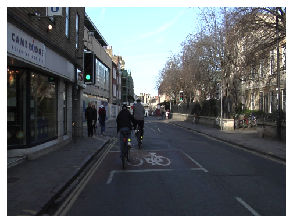

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
img.size

torch.Size([360, 480])

In [9]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

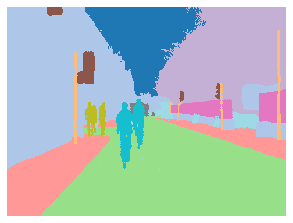

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([360, 480]), tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3]]]))

## Datasets

In [12]:
bs = 16

In [13]:
src = (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

In [14]:
data = (src.transform(get_transforms(), tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

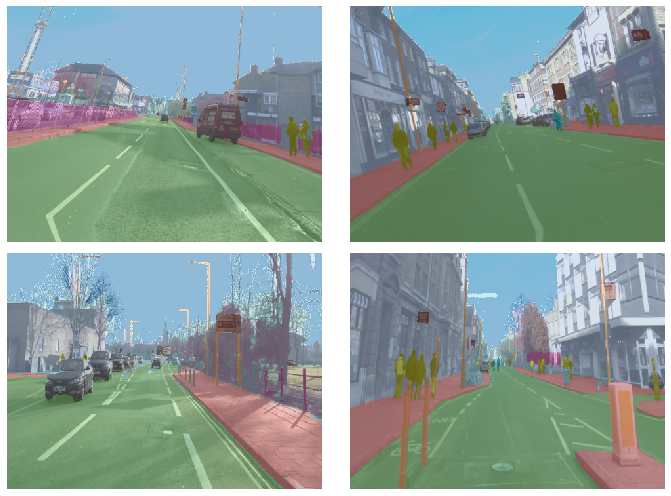

In [15]:
data.show_batch(2, figsize=(10,7))

## Model

In [16]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [17]:
metrics=acc_camvid
wd=1e-2

In [18]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


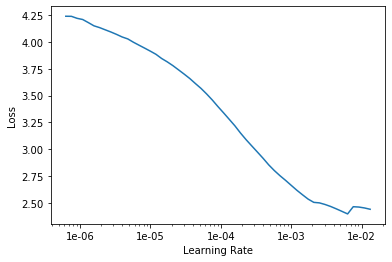

In [19]:
lr_find(learn)
learn.recorder.plot()

In [20]:
lr=2e-3
lr

0.002

In [21]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.675680,1.144837,0.635166,00:27
1,1.196908,0.919389,0.713844,00:24
2,0.948154,0.632040,0.802456,00:24
3,0.775752,0.585577,0.836296,00:24
4,0.670522,0.440800,0.868310,00:24
5,0.617554,0.439763,0.876604,00:24
6,0.558819,0.406906,0.884897,00:24
7,0.510905,0.424473,0.875964,00:24
8,0.483563,0.365920,0.886400,00:24
9,0.431666,0.325415,0.895562,00:24


In [22]:
learn.save('stage-1')

In [23]:
learn.load('stage-1');

In [24]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


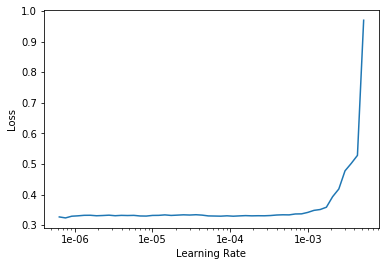

In [25]:
lr_find(learn)
learn.recorder.plot()

In [27]:
lrs = slice(lr/100,lr/2)
lrs

slice(2e-05, 0.001, None)

In [28]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.332465,0.314337,0.899547,00:25
1,0.321886,0.315581,0.897205,00:25
2,0.313610,0.304391,0.904483,00:25
3,0.301016,0.285425,0.915335,00:25
4,0.297312,0.310143,0.901978,00:25
5,0.297263,0.289411,0.918757,00:25
6,0.287570,0.277586,0.915151,00:25
7,0.282071,0.256115,0.924349,00:25
8,0.270645,0.266838,0.919683,00:25
9,0.263973,0.265659,0.926883,00:25


In [29]:
learn.save('stage-2');

## Go big

In [35]:
learn=None
gc.collect()

5744

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [36]:
size = src_size
bs=8

In [37]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [38]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


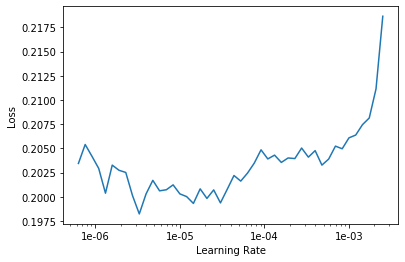

In [39]:
lr_find(learn)
learn.recorder.plot()

In [40]:
lr=1e-5

In [41]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.200167,0.242925,0.930810,00:26
1,0.198958,0.241181,0.931477,00:26
2,0.200333,0.239752,0.932281,00:26
3,0.201633,0.238468,0.932369,00:26
4,0.199353,0.237625,0.932739,00:26
5,0.197723,0.234333,0.932996,00:26
6,0.197619,0.235953,0.932565,00:26
7,0.198282,0.235083,0.932323,00:26
8,0.195935,0.231897,0.933251,00:26
9,0.195208,0.233978,0.932677,00:26


In [42]:
learn.save('stage-1-big')

In [56]:
learn.load('stage-1-big');

In [57]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


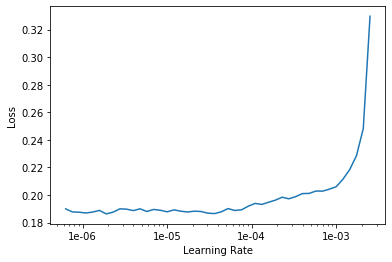

In [58]:
lr_find(learn)
learn.recorder.plot()

In [59]:
lrs = slice(1e-6, 1e-4)
lrs

slice(1e-06, 0.0001, None)

In [60]:
learn.fit_one_cycle(10, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.196711,0.233076,0.932775,00:27
1,0.191302,0.233485,0.932501,00:27
2,0.191557,0.233050,0.932802,00:27
3,0.189313,0.241443,0.930991,00:27
4,0.189848,0.229217,0.934274,00:27
5,0.189119,0.223083,0.934955,00:27
6,0.185519,0.240129,0.930816,00:27
7,0.182952,0.232420,0.934641,00:27
8,0.177605,0.243116,0.931202,00:27
9,0.172993,0.238595,0.933343,00:27


In [61]:
learn.save('stage-2-big')

In [62]:
learn.load('stage-2-big');

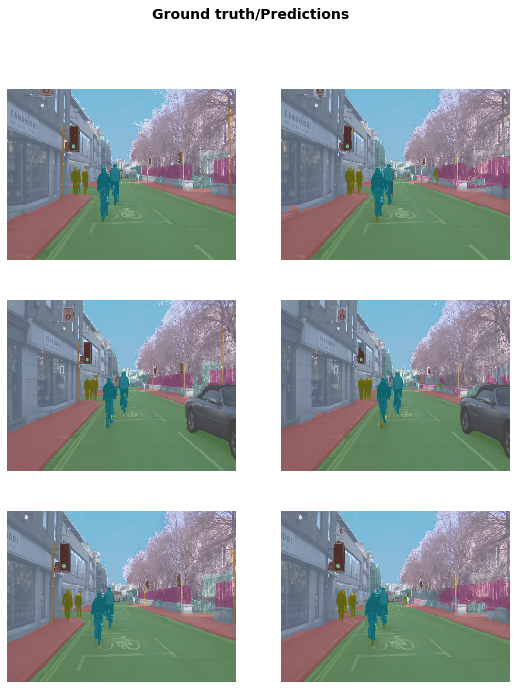

In [63]:
learn.show_results(rows=3, figsize=(9,11))

## fin

In [ ]:
# start: 480x360

In [64]:
print(learn.summary())

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 180, 240]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 180, 240]       128        True      
______________________________________________________________________
ReLU                 [64, 180, 240]       0          False     
______________________________________________________________________
MaxPool2d            [64, 90, 120]        0          False     
______________________________________________________________________
Conv2d               [64, 90, 120]        36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 90, 120]        128        True      
______________________________________________________________________
ReLU                 [64, 90, 120]        0          False     
__________________________________________________